In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

class MultilingualDataset(Dataset):
    def __init__(self, data_list, tokenizer, max_length=128):
        self.data = data_list
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        
        # Tokenize all versions of the sentence
        english = self.tokenizer(item["English"], padding="max_length", 
                                truncation=True, max_length=self.max_length, 
                                return_tensors="pt")
        
        etok = self.tokenizer(item["EtoK"], padding="max_length", 
                             truncation=True, max_length=self.max_length, 
                             return_tensors="pt")
        
        ktoe = self.tokenizer(item["KtoE"], padding="max_length", 
                             truncation=True, max_length=self.max_length, 
                             return_tensors="pt")
        
        korean = self.tokenizer(item["Korean"], padding="max_length", 
                               truncation=True, max_length=self.max_length, 
                               return_tensors="pt")
        
        # Return a flat dictionary with prefixed keys
        return {
            "english_input_ids": english["input_ids"].squeeze(0),
            "english_attention_mask": english["attention_mask"].squeeze(0),
            "etok_input_ids": etok["input_ids"].squeeze(0),
            "etok_attention_mask": etok["attention_mask"].squeeze(0),
            "ktoe_input_ids": ktoe["input_ids"].squeeze(0),
            "ktoe_attention_mask": ktoe["attention_mask"].squeeze(0),
            "korean_input_ids": korean["input_ids"].squeeze(0),
            "korean_attention_mask": korean["attention_mask"].squeeze(0)
        }


/home/kyudan/anaconda3/envs/py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import datetime
class EmbeddingFinetuner:
    def __init__(self, model_name="BAAI/bge-m3", device="cuda" if torch.cuda.is_available() else "cpu"):
        self.device = device
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(device)
        
        # Save the original model for comparison
        self.original_model = AutoModel.from_pretrained(model_name).to(device)
        self.original_model.eval()  # Set to evaluation mode
    
    def save_model(self, path="finetuned_model"):
        """
        모델을 저장합니다.
        
        Args:
            path (str): 모델을 저장할 경로/파일명 (확장자 없이)
        """
        # 모델 상태 저장
        torch.save(self.model.state_dict(), f"{path}.pt")
        
        # 설정 정보 저장 (선택사항)
        import json
        config = {
            "model_name": self.model.config._name_or_path,
            "saved_date": str(datetime.datetime.now())
        }
        
        with open(f"{path}_config.json", "w") as f:
            json.dump(config, f)
        
        print(f"모델이 '{path}.pt'에 저장되었습니다.")

    def load_model(self, path="finetuned_model"):
        """
        저장된 모델을 불러옵니다.
        
        Args:
            path (str): 불러올 모델 파일 경로 (확장자 없이)
        """
        # 모델 상태 불러오기
        self.model.load_state_dict(torch.load(f"{path}.pt"))
        self.model.eval()  # 평가 모드로 설정
        print(f"모델이 '{path}.pt'에서 불러와졌습니다.")

    def get_embedding(self, model, input_ids, attention_mask):
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.pooler_output
    
    def finetune(self, train_dataloader, num_epochs=5, lr=1e-5):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        
        self.model.train()
        
        for epoch in range(num_epochs):
            total_loss = 0
            
            for batch in train_dataloader:
                optimizer.zero_grad()
                
                # Move all inputs to device
                batch = {k: v.to(self.device) for k, v in batch.items()}
                
                # Get embeddings for all text versions
                english_embedding = self.get_embedding(
                    self.model, 
                    batch["english_input_ids"], 
                    batch["english_attention_mask"]
                )
                
                etok_embedding = self.get_embedding(
                    self.model, 
                    batch["etok_input_ids"], 
                    batch["etok_attention_mask"]
                )
                
                ktoe_embedding = self.get_embedding(
                    self.model, 
                    batch["ktoe_input_ids"], 
                    batch["ktoe_attention_mask"]
                )
                
                korean_embedding = self.get_embedding(
                    self.model, 
                    batch["korean_input_ids"], 
                    batch["korean_attention_mask"]
                )
                
                # Calculate loss as the sum of L2 distances from English embedding
                # This matches the formula: {\cal{L}}(\theta) = -\frac{1}{BT} \sum^B \sum^T_t (||Emb^{Eng} - Emb^{diff-lang}_{\theta}||_2)
                # Note: We assume the negative sign in the formula may be an error since we want to minimize distance
                batch_size = english_embedding.size(0)
                
                loss = (
                    torch.sum(torch.norm(english_embedding - etok_embedding, dim=1)) +
                    torch.sum(torch.norm(english_embedding - ktoe_embedding, dim=1)) +
                    torch.sum(torch.norm(english_embedding - korean_embedding, dim=1))
                ) / (batch_size * 3)  # Normalize by batch size and number of different languages
                
                # Backward pass and optimization
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
            
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_dataloader):.4f}")
    
    def compute_embeddings(self, data_loader, model):
        # Set model to evaluation mode
        model.eval()
        
        embeddings = {
            "english": [],
            "etok": [],
            "ktoe": [],
            "korean": []
        }
        
        with torch.no_grad():
            for batch in data_loader:
                # Move all inputs to device
                batch = {k: v.to(self.device) for k, v in batch.items()}
                
                # Compute embeddings for each type
                english_emb = self.get_embedding(
                    model, 
                    batch["english_input_ids"], 
                    batch["english_attention_mask"]
                ).cpu().numpy()
                
                etok_emb = self.get_embedding(
                    model, 
                    batch["etok_input_ids"], 
                    batch["etok_attention_mask"]
                ).cpu().numpy()
                
                ktoe_emb = self.get_embedding(
                    model, 
                    batch["ktoe_input_ids"], 
                    batch["ktoe_attention_mask"]
                ).cpu().numpy()
                
                korean_emb = self.get_embedding(
                    model, 
                    batch["korean_input_ids"], 
                    batch["korean_attention_mask"]
                ).cpu().numpy()
                
                # Store embeddings
                embeddings["english"].append(english_emb)
                embeddings["etok"].append(etok_emb)
                embeddings["ktoe"].append(ktoe_emb)
                embeddings["korean"].append(korean_emb)
        
        # Concatenate all batches
        for key in embeddings:
            if embeddings[key]:  # Check if the list is not empty
                embeddings[key] = np.concatenate(embeddings[key], axis=0)
        
        return embeddings
    
    def evaluate_embeddings(self, data_loader):
        original_embeddings = self.compute_embeddings(data_loader, self.original_model)
        finetuned_embeddings = self.compute_embeddings(data_loader, self.model)
        
        return original_embeddings, finetuned_embeddings
    
    def visualize_with_pca(self, original_embeddings, finetuned_embeddings):
        # Stack all embeddings for fitting PCA
        original_stack = np.vstack([original_embeddings[k] for k in original_embeddings])
        finetuned_stack = np.vstack([finetuned_embeddings[k] for k in finetuned_embeddings])
        
        # Fit PCA on combined data
        pca_original = PCA(n_components=2)
        pca_finetuned = PCA(n_components=2)
        
        # Transform each set of embeddings
        original_pca_result = {}
        finetuned_pca_result = {}
        
        # Fit PCA on all original embeddings
        pca_original.fit(original_stack)
        for key in original_embeddings:
            original_pca_result[key] = pca_original.transform(original_embeddings[key])
        
        # Fit PCA on all finetuned embeddings
        pca_finetuned.fit(finetuned_stack)
        for key in finetuned_embeddings:
            finetuned_pca_result[key] = pca_finetuned.transform(finetuned_embeddings[key])
        
        # Create figure for visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
        
        # Define colors and markers for each type
        colors = {
            "english": "blue",
            "etok": "green",
            "ktoe": "red",
            "korean": "purple"
        }
        
        markers = {
            "english": "o",
            "etok": "s",
            "ktoe": "^",
            "korean": "D"
        }
        
        # Plot original embeddings
        for key in original_pca_result:
            ax1.scatter(
                original_pca_result[key][:, 0], 
                original_pca_result[key][:, 1],
                color=colors[key],
                marker=markers[key],
                label=key,
                alpha=0.7
            )
        
        ax1.set_title("Original Model Embeddings (Before Fine-tuning)")
        ax1.legend()
        ax1.grid(True)
        
        # Plot finetuned embeddings
        for key in finetuned_pca_result:
            ax2.scatter(
                finetuned_pca_result[key][:, 0], 
                finetuned_pca_result[key][:, 1],
                color=colors[key],
                marker=markers[key],
                label=key,
                alpha=0.7
            )
        
        ax2.set_title("Fine-tuned Model Embeddings")
        ax2.legend()
        ax2.grid(True)
        
        plt.suptitle("Comparing Embeddings Before and After Fine-tuning")
        plt.tight_layout()
        plt.savefig("embedding_comparison.png")
        plt.show()
        
        # Calculate and report average distances
        print("\nAverage L2 distances from English embeddings:")
        print("Before fine-tuning:")
        for key in ["etok", "ktoe", "korean"]:
            avg_dist = np.mean(np.linalg.norm(
                original_embeddings["english"] - original_embeddings[key], axis=1
            ))
            print(f"  English to {key}: {avg_dist:.4f}")
        
        print("\nAfter fine-tuning:")
        for key in ["etok", "ktoe", "korean"]:
            avg_dist = np.mean(np.linalg.norm(
                finetuned_embeddings["english"] - finetuned_embeddings[key], axis=1
            ))
            print(f"  English to {key}: {avg_dist:.4f}")


Epoch 1/30, Loss: 7.7941
Epoch 2/30, Loss: 5.0537
Epoch 3/30, Loss: 4.0952
Epoch 4/30, Loss: 3.2657
Epoch 5/30, Loss: 2.9089
Epoch 6/30, Loss: 2.5910
Epoch 7/30, Loss: 2.2864
Epoch 8/30, Loss: 2.2685
Epoch 9/30, Loss: 2.0213
Epoch 10/30, Loss: 1.8980
Epoch 11/30, Loss: 1.8456
Epoch 12/30, Loss: 1.7466
Epoch 13/30, Loss: 1.6796
Epoch 14/30, Loss: 1.6574
Epoch 15/30, Loss: 1.5374
Epoch 16/30, Loss: 1.4937
Epoch 17/30, Loss: 1.4026
Epoch 18/30, Loss: 1.4890
Epoch 19/30, Loss: 1.3501
Epoch 20/30, Loss: 1.3623
Epoch 21/30, Loss: 1.3161
Epoch 22/30, Loss: 1.2166
Epoch 23/30, Loss: 1.1994
Epoch 24/30, Loss: 1.1762
Epoch 25/30, Loss: 1.1746
Epoch 26/30, Loss: 1.1238
Epoch 27/30, Loss: 1.0796
Epoch 28/30, Loss: 1.2564
Epoch 29/30, Loss: 1.1250
Epoch 30/30, Loss: 1.0855


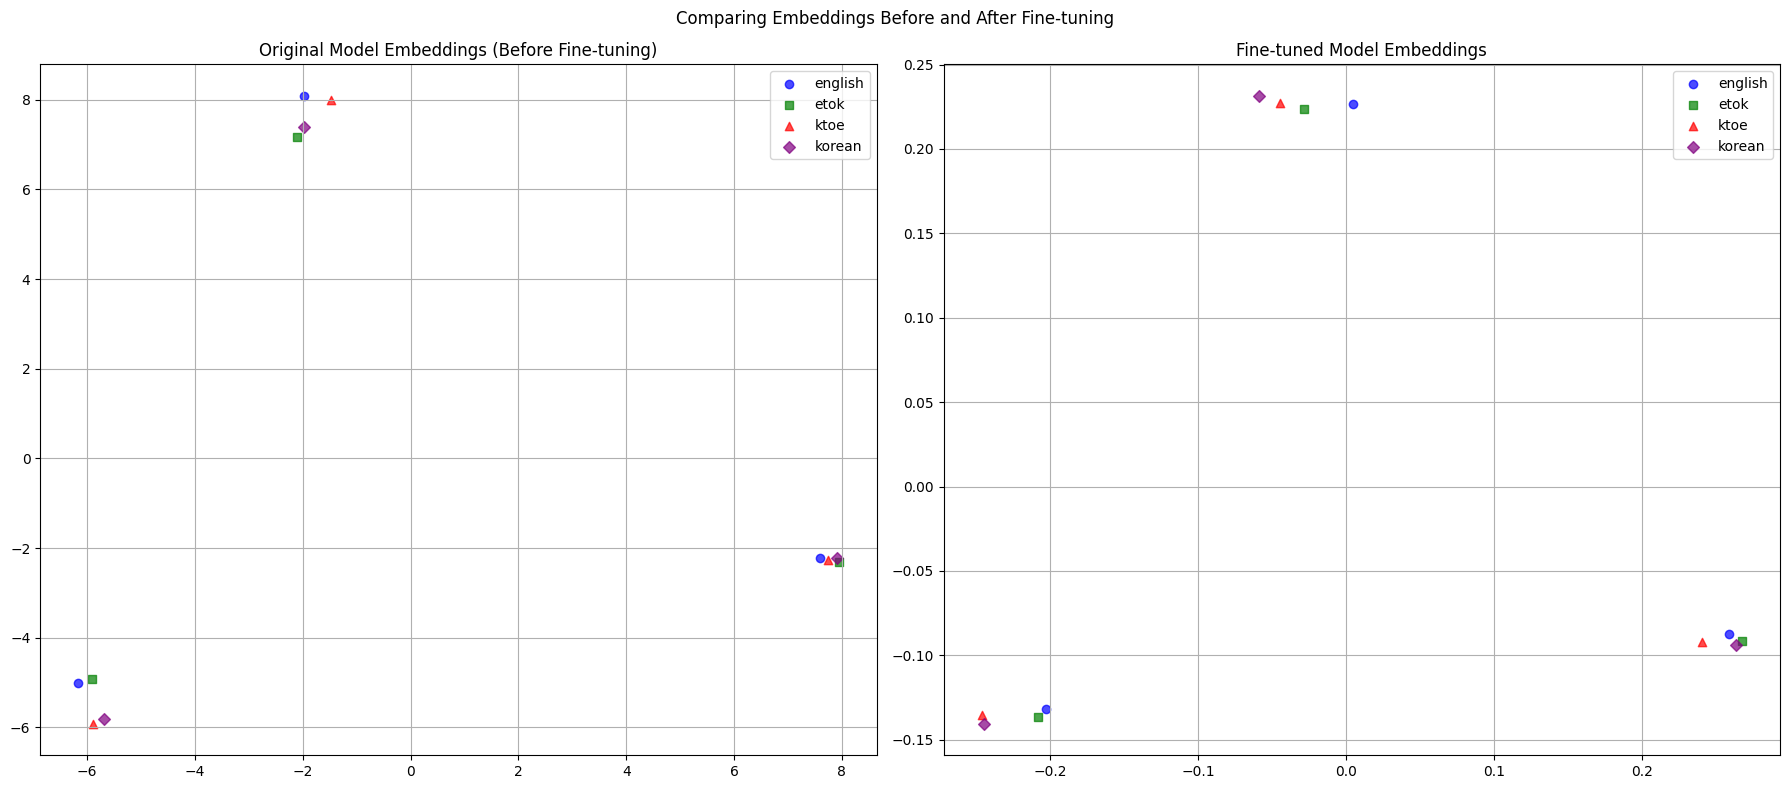


Average L2 distances from English embeddings:
Before fine-tuning:
  English to etok: 6.0677
  English to ktoe: 5.2291
  English to korean: 7.7757

After fine-tuning:
  English to etok: 0.0857
  English to ktoe: 0.1171
  English to korean: 0.1384


In [3]:

def main():
    # Example data with multiple samples for training
    data = [
        {
            "EtoK": "Could you explain how 나노 로봇 and 자기장 조작 can deliver drugs to specific cells?",
            "KtoE": "Nanorobotics와 magnetic control을 활용해 특정 세포에 약물을 운반하는 원리는 무엇인가요?",
            "English": "Could you explain how nanorobotics and magnetic control can deliver drugs to specific cells?",
            "Korean": "나노 로봇과 자기장 조작을 통해 특정 세포로 약물을 전달하는 원리는 무엇인가요?"
        },
        {
            "EtoK": "The 인공지능 system can 학습 from large datasets.",
            "KtoE": "artificial intelligence 시스템은 대규모 데이터셋에서 learn 할 수 있습니다.",
            "English": "The artificial intelligence system can learn from large datasets.",
            "Korean": "인공지능 시스템은 대규모 데이터셋에서 학습할 수 있습니다."
        },
        {
            "EtoK": "Can 양자 컴퓨팅 solve problems that 고전적 컴퓨터 cannot?",
            "KtoE": "Quantum computing이 classical computers가 해결할 수 없는 문제를 해결할 수 있을까요?",
            "English": "Can quantum computing solve problems that classical computers cannot?",
            "Korean": "양자 컴퓨팅이 고전적 컴퓨터가 해결할 수 없는 문제를 해결할 수 있을까요?"
        }
    ]
    
    # Initialize the finetuner
    finetuner = EmbeddingFinetuner()
    
    # Create dataset and dataloader
    dataset = MultilingualDataset(data, finetuner.tokenizer)
    dataloader = DataLoader(dataset, batch_size=2, shuffle=True)
    
    # Finetune the model
    finetuner.finetune(dataloader, num_epochs=30, lr=2e-5)
    
    finetuner.save_model("multilingual_embedding_model")
    
    # Evaluate embeddings
    original_embeddings, finetuned_embeddings = finetuner.evaluate_embeddings(dataloader)
    
    # Visualize results
    finetuner.visualize_with_pca(original_embeddings, finetuned_embeddings)

if __name__ == "__main__":

    
    main()